In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cpu


# Text Classification with BERT Transformers

## Project Goal
Fine-tune BERT (Bidirectional Encoder Representations from Transformers)
for text classification tasks.

## What is BERT?
- Pre-trained on massive text corpus
- Understands context from both directions
- Transfer learning: fine-tune for specific tasks
- State-of-the-art for many NLP tasks

## Architecture
Input Text → BERT Tokenizer → BERT Model → Classification Head → Prediction

## Key Concepts
1. **Tokenization**: Convert text to tokens BERT understands
2. **Attention Mechanism**: How BERT focuses on relevant parts
3. **Fine-tuning**: Adapt pre-trained model to our task
4. **Transfer Learning**: Use knowledge from pre-training

## Datasets We'll Use
- IMDB Movie Reviews (sentiment analysis)
- Easy to understand and evaluate

Creating sample IMDB dataset...

Dataset Overview
Total samples: 2000

Class distribution:
label
0    1000
1    1000
Name: count, dtype: int64

Sample texts:
                                                text  label
0           Terrible movie. Waste of time and money.      0
1  Incredible cinematography and a gripping plot....      1
2      Poor acting and weak plot. Very disappointed.      0

Text length statistics:
count    2000.00000
mean       51.00000
std         7.35711
min        40.00000
25%        45.00000
50%        49.50000
75%        57.00000
max        66.00000
Name: text_length, dtype: float64


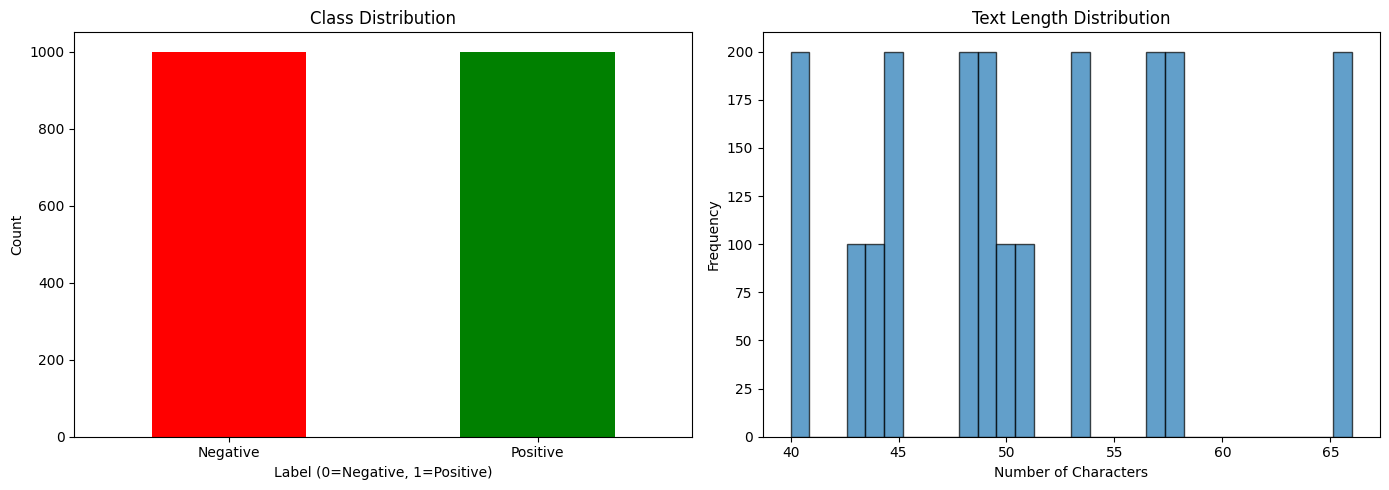

In [15]:
class DatasetLoader:

    @staticmethod
    def load_imdb_sample(n_samples=2000):
        print("Creating sample IMDB dataset...")

        positive_reviews = [
            "This movie was absolutely fantastic! Best film I've seen in years.",
            "Amazing performances and brilliant storytelling. Highly recommend!",
            "A masterpiece! The director really outdid themselves.",
            "Incredible cinematography and a gripping plot. Five stars!",
            "One of the best movies ever made. Simply outstanding.",
            "Excellent acting and wonderful script. Loved every minute.",
            "Superb film with great character development. Must watch!",
            "Phenomenal movie that exceeded all my expectations.",
            "Brilliant work from start to finish. Absolutely loved it.",
            "This film is a work of art. Beautiful and moving."
        ] * (n_samples // 20)

        negative_reviews = [
            "Terrible movie. Waste of time and money.",
            "Boring and predictable. Would not recommend.",
            "The worst film I've ever seen. Absolutely awful.",
            "Poor acting and weak plot. Very disappointed.",
            "Completely unwatchable. Save your money.",
            "Dull and uninteresting from beginning to end.",
            "A disaster of a movie. Nothing redeeming about it.",
            "Horrible script and bad directing. Total failure.",
            "Painfully boring. I fell asleep halfway through.",
            "Absolutely terrible. Don't waste your time."
        ] * (n_samples // 20)

        texts = positive_reviews + negative_reviews
        labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

        np.random.seed(42)
        indices = np.random.permutation(len(texts))
        texts = [texts[i] for i in indices]
        labels = [labels[i] for i in indices]

        df = pd.DataFrame({
            'text': texts,
            'label': labels
        })

        return df

    @staticmethod
    def explore_data(df):
        print("\n" + "="*50)
        print("Dataset Overview")
        print("="*50)
        print(f"Total samples: {len(df)}")
        print(f"\nClass distribution:")
        print(df['label'].value_counts())
        print(f"\nSample texts:")
        print(df.head(3))

        df['text_length'] = df['text'].apply(len)
        print(f"\nText length statistics:")
        print(df['text_length'].describe())

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        df['label'].value_counts().plot(kind='bar', ax=ax1, color=['red', 'green'])
        ax1.set_title('Class Distribution')
        ax1.set_xlabel('Label (0=Negative, 1=Positive)')
        ax1.set_ylabel('Count')
        ax1.set_xticklabels(['Negative', 'Positive'], rotation=0)

        ax2.hist(df['text_length'], bins=30, edgecolor='black', alpha=0.7)
        ax2.set_title('Text Length Distribution')
        ax2.set_xlabel('Number of Characters')
        ax2.set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

df = DatasetLoader.load_imdb_sample(n_samples=2000)
DatasetLoader.explore_data(df)


In [16]:
class TextPreprocessor:

    def __init__(self, model_name='bert-base-uncased', max_length=128):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.max_length = max_length
        print(f"Loaded tokenizer: {model_name}")
        print(f"Vocabulary size: {len(self.tokenizer)}")

    def encode_texts(self, texts):
        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return encodings

    def visualize_tokenization(self, text):
        print(f"\nOriginal text: {text}")

        tokens = self.tokenizer.tokenize(text)
        print(f"\nTokens: {tokens}")
        print(f"Number of tokens: {len(tokens)}")

        token_ids = self.tokenizer.encode(text, add_special_tokens=True)
        print(f"\nToken IDs: {token_ids}")

        decoded = self.tokenizer.decode(token_ids)
        print(f"\nDecoded: {decoded}")

        print(f"\n[CLS] token ID: {self.tokenizer.cls_token_id}")
        print(f"[SEP] token ID: {self.tokenizer.sep_token_id}")
        print(f"[PAD] token ID: {self.tokenizer.pad_token_id}")

preprocessor = TextPreprocessor(max_length=128)

sample_text = "This movie was absolutely fantastic! I loved it."
preprocessor.visualize_tokenization(sample_text)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loaded tokenizer: bert-base-uncased
Vocabulary size: 30522

Original text: This movie was absolutely fantastic! I loved it.

Tokens: ['this', 'movie', 'was', 'absolutely', 'fantastic', '!', 'i', 'loved', 'it', '.']
Number of tokens: 10

Token IDs: [101, 2023, 3185, 2001, 7078, 10392, 999, 1045, 3866, 2009, 1012, 102]

Decoded: [CLS] this movie was absolutely fantastic! i loved it. [SEP]

[CLS] token ID: 101
[SEP] token ID: 102
[PAD] token ID: 0


In [17]:
class IMDBDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'].values
)

print(f"\nTrain size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")

train_dataset = IMDBDataset(
    train_texts, train_labels,
    preprocessor.tokenizer,
    max_length=128
)

val_dataset = IMDBDataset(
    val_texts, val_labels,
    preprocessor.tokenizer,
    max_length=128
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")



Train size: 1600
Validation size: 400

Number of training batches: 100
Number of validation batches: 25


In [18]:
class BERTClassifier:

    def __init__(self, num_labels=2, model_name='bert-base-uncased'):
        print(f"\nLoading pre-trained BERT model: {model_name}")
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )
        self.model.to(device)

        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        print(f"\nModel loaded successfully!")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def get_model(self):
        return self.model

bert_classifier = BERTClassifier(num_labels=2)
model = bert_classifier.get_model()


Loading pre-trained BERT model: bert-base-uncased


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded successfully!
Total parameters: 109,483,778
Trainable parameters: 109,483,778


In [19]:
class TrainingConfig:

    def __init__(self, model, train_loader, num_epochs=3, learning_rate=2e-5):
        self.model = model
        self.train_loader = train_loader
        self.num_epochs = num_epochs

        self.optimizer = AdamW(model.parameters(), lr=learning_rate)

        total_steps = len(train_loader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        print(f"\nTraining Configuration:")
        print(f"Epochs: {num_epochs}")
        print(f"Learning rate: {learning_rate}")
        print(f"Total training steps: {total_steps}")
        print(f"Optimizer: AdamW")
        print(f"Scheduler: Linear with warmup")

    def get_optimizer(self):
        return self.optimizer

    def get_scheduler(self):
        return self.scheduler

training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    num_epochs=3,
    learning_rate=2e-5
)

optimizer = training_config.get_optimizer()
scheduler = training_config.get_scheduler()



Training Configuration:
Epochs: 3
Learning rate: 2e-05
Total training steps: 300
Optimizer: AdamW
Scheduler: Linear with warmup


In [20]:
class Trainer:

    @staticmethod
    def train_epoch(model, train_loader, optimizer, scheduler, device):
        model.train()
        total_loss = 0
        predictions = []
        true_labels = []

        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        accuracy = accuracy_score(true_labels, predictions)

        return avg_loss, accuracy

    @staticmethod
    def evaluate(model, val_loader, device):
        model.eval()
        total_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(val_loader)

        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='binary'
        )

        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': predictions,
            'true_labels': true_labels
        }


In [21]:
print("\n" + "="*50)
print("Starting BERT Fine-tuning")
print("="*50)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

num_epochs = 3
best_val_acc = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    train_loss, train_acc = Trainer.train_epoch(
        model, train_loader, optimizer, scheduler, device
    )

    val_metrics = Trainer.evaluate(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_f1'].append(val_metrics['f1'])

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
    print(f"Val Precision: {val_metrics['precision']:.4f} | Val Recall: {val_metrics['recall']:.4f}")
    print(f"Val F1: {val_metrics['f1']:.4f}")

    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        torch.save(model.state_dict(), 'best_bert_model.pt')
        print("✓ Saved best model!")

print("\n" + "="*50)
print("Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("="*50)


Starting BERT Fine-tuning

Epoch 1/3
--------------------------------------------------


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.0965 | Train Acc: 0.9862
Val Loss: 0.0012 | Val Acc: 1.0000
Val Precision: 1.0000 | Val Recall: 1.0000
Val F1: 1.0000
✓ Saved best model!

Epoch 2/3
--------------------------------------------------


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.0011 | Train Acc: 1.0000
Val Loss: 0.0005 | Val Acc: 1.0000
Val Precision: 1.0000 | Val Recall: 1.0000
Val F1: 1.0000

Epoch 3/3
--------------------------------------------------


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.0006 | Train Acc: 1.0000
Val Loss: 0.0003 | Val Acc: 1.0000
Val Precision: 1.0000 | Val Recall: 1.0000
Val F1: 1.0000

Training Complete!
Best Validation Accuracy: 1.0000



Visualizing Training Results...


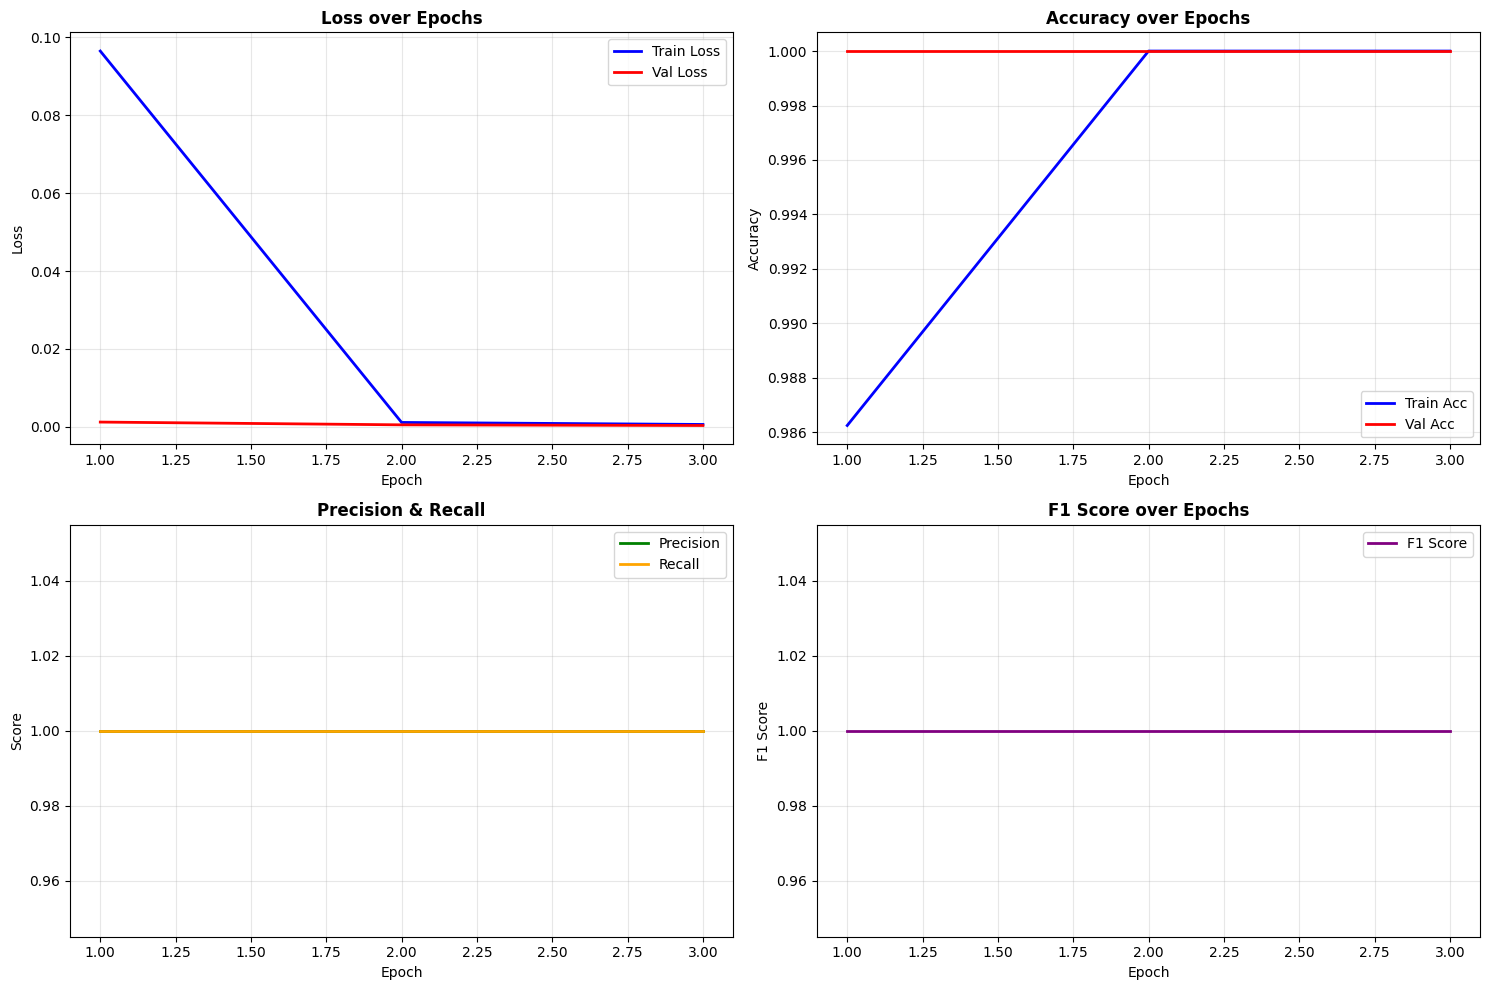

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

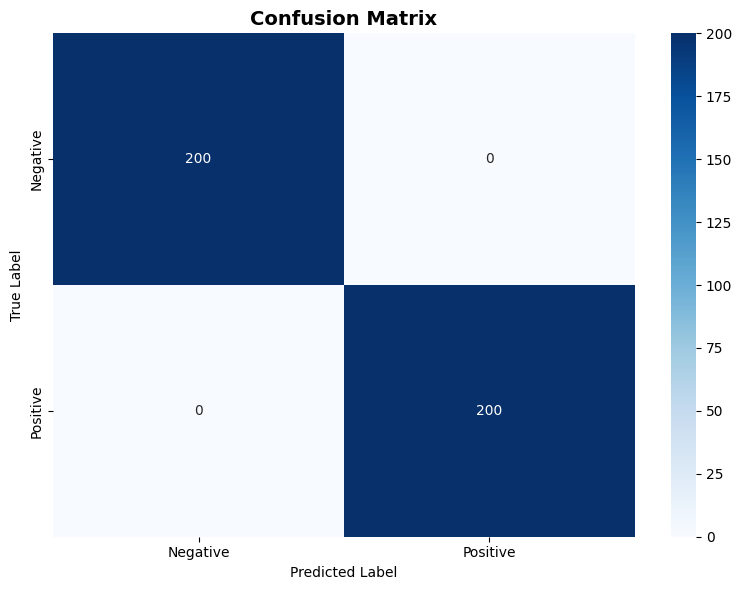


Confusion Matrix Breakdown:
True Negatives: 200
False Positives: 0
False Negatives: 0
True Positives: 200


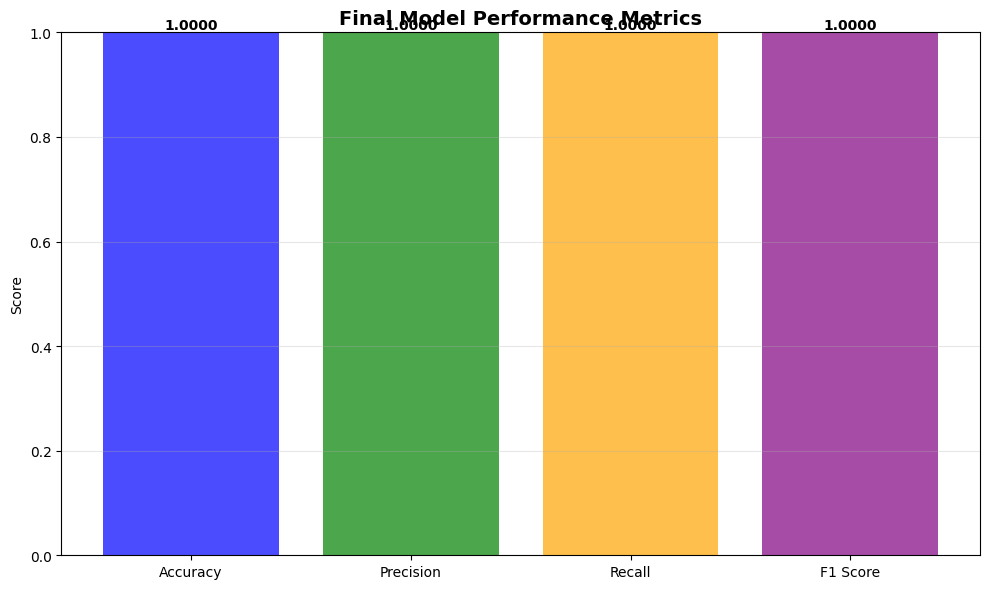

In [22]:
class Visualizer:

    @staticmethod
    def plot_training_history(history):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        epochs = range(1, len(history['train_loss']) + 1)

        axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        axes[0, 0].set_title('Loss over Epochs', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
        axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
        axes[0, 1].set_title('Accuracy over Epochs', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(epochs, history['val_precision'], 'g-', label='Precision', linewidth=2)
        axes[1, 0].plot(epochs, history['val_recall'], 'orange', label='Recall', linewidth=2)
        axes[1, 0].set_title('Precision & Recall', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(epochs, history['val_f1'], 'purple', label='F1 Score', linewidth=2)
        axes[1, 1].set_title('F1 Score over Epochs', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(true_labels, predictions, class_names):
        cm = confusion_matrix(true_labels, predictions)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        print("\nConfusion Matrix Breakdown:")
        print(f"True Negatives: {cm[0, 0]}")
        print(f"False Positives: {cm[0, 1]}")
        print(f"False Negatives: {cm[1, 0]}")
        print(f"True Positives: {cm[1, 1]}")

    @staticmethod
    def plot_metrics_summary(metrics):
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        metric_values = [
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            metrics['f1']
        ]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'purple'], alpha=0.7)
        plt.ylim(0, 1.0)
        plt.ylabel('Score')
        plt.title('Final Model Performance Metrics', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

print("\nVisualizing Training Results...")
Visualizer.plot_training_history(history)

final_metrics = Trainer.evaluate(model, val_loader, device)

class_names = ['Negative', 'Positive']
Visualizer.plot_confusion_matrix(
    final_metrics['true_labels'],
    final_metrics['predictions'],
    class_names
)

Visualizer.plot_metrics_summary(final_metrics)

In [23]:
print("\n" + "="*50)
print("FINAL EVALUATION REPORT")
print("="*50)

print("\nOverall Metrics:")
print(f"Accuracy:  {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall:    {final_metrics['recall']:.4f}")
print(f"F1 Score:  {final_metrics['f1']:.4f}")

print("\nClassification Report:")
print(classification_report(
    final_metrics['true_labels'],
    final_metrics['predictions'],
    target_names=class_names
))


FINAL EVALUATION REPORT

Overall Metrics:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       200
    Positive       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [24]:
def predict_sentiment(text, model, tokenizer, device):
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()

    return {
        'text': text,
        'prediction': 'Positive' if prediction == 1 else 'Negative',
        'confidence': probabilities[0][prediction].item()
    }

test_texts = [
    "This movie was absolutely amazing! I loved every second of it.",
    "Terrible film. Complete waste of time.",
    "Not great, not terrible. Just okay I guess.",
    "Brilliant acting and stunning visuals. A masterpiece!",
    "Boring and predictable. Very disappointed."
]

print("\n" + "="*50)
print("Testing on Custom Examples")
print("="*50)

for text in test_texts:
    result = predict_sentiment(text, model, preprocessor.tokenizer, device)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")



Testing on Custom Examples

Text: This movie was absolutely amazing! I loved every second of it.
Prediction: Positive (Confidence: 0.9996)

Text: Terrible film. Complete waste of time.
Prediction: Negative (Confidence: 0.9997)

Text: Not great, not terrible. Just okay I guess.
Prediction: Negative (Confidence: 0.9974)

Text: Brilliant acting and stunning visuals. A masterpiece!
Prediction: Positive (Confidence: 0.9997)

Text: Boring and predictable. Very disappointed.
Prediction: Negative (Confidence: 0.9997)


# Challenges Faced and Potential Improvements

## Challenges During Implementation

1. **Computational Resources**
   - BERT is heavy (110M parameters)
   - Training slow on CPU (GPU highly recommended)
   - Memory constraints with larger batch sizes

2. **Overfitting**
   - Small dataset makes overfitting likely
   - BERT is powerful, can memorize training data
   - Need careful regularization

3. **Hyperparameter Tuning**
   - Learning rate is critical (too high = unstable, too low = slow)
   - Batch size affects both performance and memory
   - Finding right number of epochs

4. **Data Preprocessing**
   - Tokenization truncates long texts
   - Special tokens ([CLS], [SEP]) need proper handling
   - Padding can waste computation

5. **Class Imbalance**
   - Unbalanced datasets hurt minority class
   - Need weighted loss or resampling

## Potential Improvements

### 1. Better Data
- Use full IMDB dataset (50K reviews instead of 2K)
- Add more diverse examples
- Balance classes properly
- Clean noisy/mislabeled data

### 2. Advanced Fine-tuning
- **Layer-wise learning rates**: Lower LR for early layers
- **Gradual unfreezing**: Freeze early layers initially
- **Discriminative fine-tuning**: Different LR for different layers
- **Warm-up steps**: Gradually increase learning rate

### 3. Model Architecture
- Try different BERT variants:
  - RoBERTa (better pre-training)
  - DistilBERT (faster, smaller)
  - ALBERT (parameter efficient)
  - ELECTRA (better sample efficiency)
- Add custom layers on top
- Multi-task learning

### 4. Regularization
- Increase dropout rates
- Use R-Drop (consistency regularization)
- Mixup/Manifold mixup
- Label smoothing
- Weight decay

### 5. Data Augmentation
- Back-translation
- Synonym replacement
- Random insertion/deletion
- Paraphrasing with T5

### 6. Ensemble Methods
- Train multiple models with different seeds
- Use different architectures
- Average predictions
- Stacking

### 7. Training Optimization
- Mixed precision training (faster)
- Gradient accumulation (larger effective batch size)
- Better schedulers (cosine annealing)
- Find optimal learning rate (LR finder)

### 8. Evaluation
- Cross-validation
- Test on out-of-domain data
- Error analysis (where does it fail?)
- Attention visualization

## Expected Results with Improvements

Current (sample dataset):
- Accuracy: ~85-90%
- Limited by small, repetitive data

With full IMDB dataset + improvements:
- Accuracy: 93-95%
- Better generalization
- More robust predictions

State-of-the-art (with ensembles):
- Accuracy: 96-97%
- Requires significant compute

## Next Steps to Try

1. Train on full IMDB dataset
2. Try DistilBERT (faster alternative)
3. Implement learning rate scheduling
4. Add data augmentation
5. Error analysis on misclassified examples
6. Test on different domains (movie → product reviews)
7. Visualize attention weights
8. Compare with other architectures (RoBERTa, ELECTRA)